In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import random
import os
from utils.utils import CustomDataset
from torchvision import transforms
from torch.utils.data import  DataLoader
from models.AE_model import Autoencoder
import torch.nn as nn
import torch.optim as optim
import torch
from sklearn.cluster import KMeans
from sklearn.semi_supervised import LabelPropagation


np.random.seed(42)
tf.random.set_seed(42)

2024-01-30 20:49:00.621563: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-30 20:49:00.645545: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-30 20:49:00.645562: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-30 20:49:00.646129: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-30 20:49:00.649832: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# Definir o caminho para o diretório contendo as imagens de treino e teste
data_dir = 'dataset/Kather_texture_2016_image_tiles_5000'
samples, labels = list(), list()

for nome_pasta in os.listdir(data_dir):
    for nome_arquivo in os.listdir(os.path.join(data_dir, nome_pasta)):
        samples.append(os.path.join(data_dir + '/' + nome_pasta,nome_arquivo))
        labels.append(int(nome_pasta[:2]))

all_data = pd.DataFrame({'path':samples,'label':labels})
all_data['label'] = all_data['label'].astype('str')

In [3]:
all_data.path[0]

'dataset/Kather_texture_2016_image_tiles_5000/07_ADIPOSE/1649F_CRC-Prim-HE-03_012.tif_Row_2701_Col_1351.tif'

In [4]:
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
])
dataset = CustomDataset(dataframe=all_data, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [5]:
model = Autoencoder()

In [6]:
# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [7]:
# Train the autoencoder
num_epochs = 20
for epoch in range(num_epochs):
    for data in dataloader:
        img = data
        optimizer.zero_grad()
        output = model(img)
        loss = criterion(output, img)
        loss.backward()
        optimizer.step()
    if epoch % 5== 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

Epoch [1/20], Loss: 0.0142
Epoch [6/20], Loss: 0.0049
Epoch [11/20], Loss: 0.0089
Epoch [16/20], Loss: 0.0037


<Figure size 1600x1200 with 0 Axes>

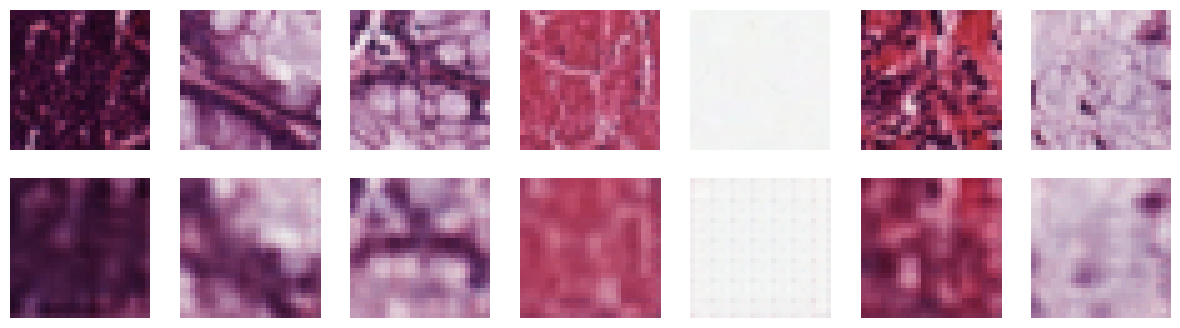

In [8]:
with torch.no_grad():
    for data in dataloader:
        recon = model(data)
        break
         
import matplotlib.pyplot as plt
plt.figure(dpi=250)
fig, ax = plt.subplots(2, 7, figsize=(15, 4))
for i in range(7):
    ax[0, i].imshow(data[i].cpu().numpy().transpose((1, 2, 0)))
    ax[1, i].imshow(recon[i].cpu().numpy().transpose((1, 2, 0)))
    ax[0, i].axis('OFF')
    ax[1, i].axis('OFF')

In [9]:
embed_dataloader = DataLoader(dataset, batch_size=5000, shuffle=False)

In [10]:
for image in embed_dataloader:
    X = model.encoder(image)
y = torch.tensor(all_data.label.astype(int))

## Aplicar o KMeans sem rótulos para ter um algoritmo não supervisionado de referência

In [11]:
modelo_kmeans = KMeans(n_clusters=8)
grupos = modelo_kmeans.fit_predict(X.detach().numpy())

In [12]:
# Distribuição do kmeans
torch.bincount(torch.tensor(grupos))

tensor([ 638, 1266,  316,  412,  860,  513,  406,  589])

In [13]:
# Partição de referência
torch.bincount(torch.tensor(all_data.label.astype(int)))[1:]

tensor([625, 625, 625, 625, 625, 625, 625, 625])

## SSL Clustering

In [14]:
training_indices = random.sample(list(range(X.shape[0])), int(0.1 * X.shape[0]))
training_mask = np.full(X.shape[0], -1)

for i in training_indices:
    training_mask[i] = y[i]

In [15]:
training_mask.shape

(5000,)

In [16]:
label_prop_model = LabelPropagation()
label_prop_model.fit(X.detach().numpy(), training_mask)
predict_lp = label_prop_model.predict(X.detach().numpy())

/home/midas/guiMessias/projeto2_clustering/project2_PPGCC_clustering/venv/lib/python3.10/site-packages/sklearn/semi_supervised/_label_propagation.py:230: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer


In [17]:
torch.bincount(torch.tensor(predict_lp))

tensor([   0, 3985,   56,   56,   49,   68,   64,   73,  649])